## Import Dependency

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, auc, f1_score, confusion_matrix,
    classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap 

## Data Preprocessing

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load Pre-processed Datasets
print("Loading pre-processed datasets for Data Transformation...")
try:
    fraud_data = pd.read_csv('../data/Fraud_Data_merged.csv')
    creditcard_data = pd.read_csv('../data/creditcard_cleaned.csv')

    if 'signup_time' in fraud_data.columns and not pd.api.types.is_datetime64_any_dtype(fraud_data['signup_time']):
        fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'], errors='coerce')
    if 'purchase_time' in fraud_data.columns and not pd.api.types.is_datetime64_any_dtype(fraud_data['purchase_time']):
        fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'], errors='coerce')

    initial_rows_fraud = fraud_data.shape[0]
    fraud_data.dropna(subset=['signup_time', 'purchase_time'], inplace=True)
    if fraud_data.shape[0] < initial_rows_fraud:
        print(f"Dropped {initial_rows_fraud - fraud_data.shape[0]} rows from Fraud_Data due to invalid signup_time or purchase_time after loading merged CSV.")
    
    print("Pre-processed datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the specified CSV files are in the same directory as this script.")
    exit()

# define features and target
X_fraud = fraud_data.drop(columns=[
    'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class'
])
y_fraud = fraud_data['class']

X_creditcard = creditcard_data.drop(columns=['Time', 'Class'])
y_creditcard = creditcard_data['Class']

# Train-Test Split
print("\nPerforming Train-Test Split...")
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)
X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test = train_test_split(
    X_creditcard, y_creditcard, test_size=0.3, random_state=42, stratify=y_creditcard
)

# Handle Class Imbalance & Encode Categorical Features (for Fraud_Data.csv)
print("\nHandling Class Imbalance & Encoding Categorical Features...")
numerical_cols_fraud_train = X_fraud_train.select_dtypes(include=np.number).columns
categorical_cols_fraud_train = X_fraud_train.select_dtypes(include='object').columns

encoder_fraud_smote = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_fraud_train_cat_encoded = encoder_fraud_smote.fit_transform(X_fraud_train[categorical_cols_fraud_train])
X_fraud_train_cat_encoded_df = pd.DataFrame(X_fraud_train_cat_encoded, columns=encoder_fraud_smote.get_feature_names_out(categorical_cols_fraud_train), index=X_fraud_train.index)
X_fraud_train_combined = pd.concat([X_fraud_train[numerical_cols_fraud_train], X_fraud_train_cat_encoded_df], axis=1)

smote = SMOTE(random_state=42)
X_fraud_train_res, y_fraud_train_res = smote.fit_resample(X_fraud_train_combined, y_fraud_train)
print(f"Fraud_Data training set resampled shape (SMOTE): {Counter(y_fraud_train_res)}")

# Handle Class Imbalance (for creditcard.csv)
rus = RandomUnderSampler(random_state=42)
X_creditcard_train_res, y_creditcard_train_res = rus.fit_resample(X_creditcard_train, y_creditcard_train)
print(f"Creditcard_Data training set resampled shape (RandomUnderSampler): {Counter(y_creditcard_train_res)}")

# Normalization and Scaling

scaler_fraud = StandardScaler()
numerical_cols_fraud_resampled = X_fraud_train_res.columns # All columns are numerical after encoding
X_fraud_train_res[numerical_cols_fraud_resampled] = scaler_fraud.fit_transform(X_fraud_train_res[numerical_cols_fraud_resampled])


X_fraud_test_cat_encoded = encoder_fraud_smote.transform(X_fraud_test[categorical_cols_fraud_train])
X_fraud_test_cat_encoded_df = pd.DataFrame(X_fraud_test_cat_encoded, columns=encoder_fraud_smote.get_feature_names_out(categorical_cols_fraud_train), index=X_fraud_test.index)

X_fraud_test_combined = pd.concat([X_fraud_test[numerical_cols_fraud_train], X_fraud_test_cat_encoded_df], axis=1)

X_fraud_test_combined = X_fraud_test_combined.reindex(columns=X_fraud_train_res.columns, fill_value=0)

X_fraud_test_scaled_np = scaler_fraud.transform(X_fraud_test_combined)
X_fraud_test = pd.DataFrame(X_fraud_test_scaled_np, columns=X_fraud_train_res.columns, index=X_fraud_test_combined.index)



scaler_creditcard = StandardScaler()
numerical_cols_creditcard = X_creditcard_train_res.select_dtypes(include=np.number).columns
X_creditcard_train_res[numerical_cols_creditcard] = scaler_creditcard.fit_transform(X_creditcard_train_res[numerical_cols_creditcard])
X_creditcard_test[numerical_cols_creditcard] = scaler_creditcard.transform(X_creditcard_test[numerical_cols_creditcard])


Loading pre-processed datasets for Data Transformation...
Pre-processed datasets loaded successfully.

Performing Train-Test Split...

Handling Class Imbalance & Encoding Categorical Features...
Fraud_Data training set resampled shape (SMOTE): Counter({0: 95872, 1: 95872})
Creditcard_Data training set resampled shape (RandomUnderSampler): Counter({0: 331, 1: 331})

Performing Normalization and Scaling...


## Model training

In [3]:
rf_fraud = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_creditcard = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')

print("\nTraining Random Forest for Fraud_Data...")
rf_fraud.fit(X_fraud_train_res, y_fraud_train_res)
print("Random Forest for Fraud_Data trained.")

print("\nTraining Random Forest for Creditcard_Data...")
rf_creditcard.fit(X_creditcard_train_res, y_creditcard_train_res)
print("Random Forest for Creditcard_Data trained.")



Training Random Forest for Fraud_Data...


Random Forest for Fraud_Data trained.

Training Random Forest for Creditcard_Data...
Random Forest for Creditcard_Data trained.


## Model Explainability


--- Starting Task 3: Model Explainability with SHAP ---

Interpreting Random Forest Model for Fraud_Data.csv...


 98%|===================| 195/200 [00:36<00:00]        


Generating SHAP Summary Plot for Fraud_Data.csv...


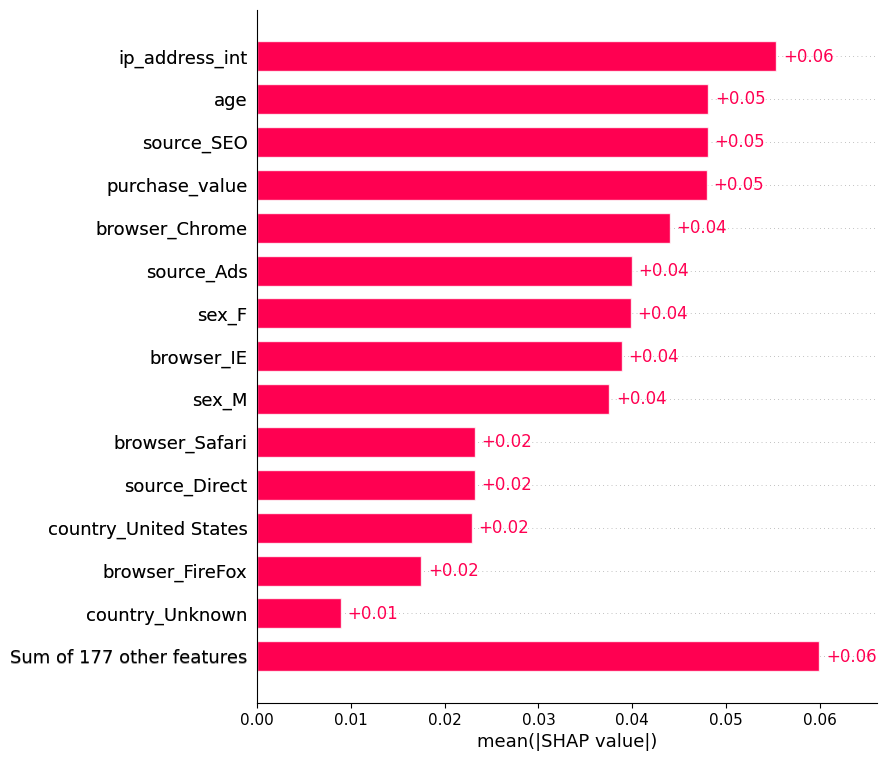

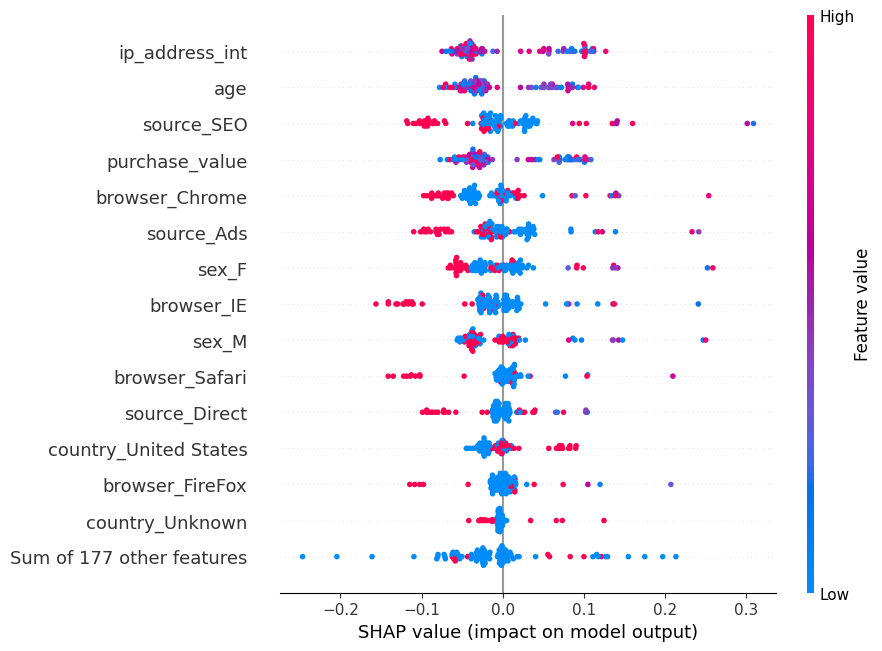


Interpreting Random Forest Model for Creditcard.csv...

Generating SHAP Summary Plot for Creditcard.csv...


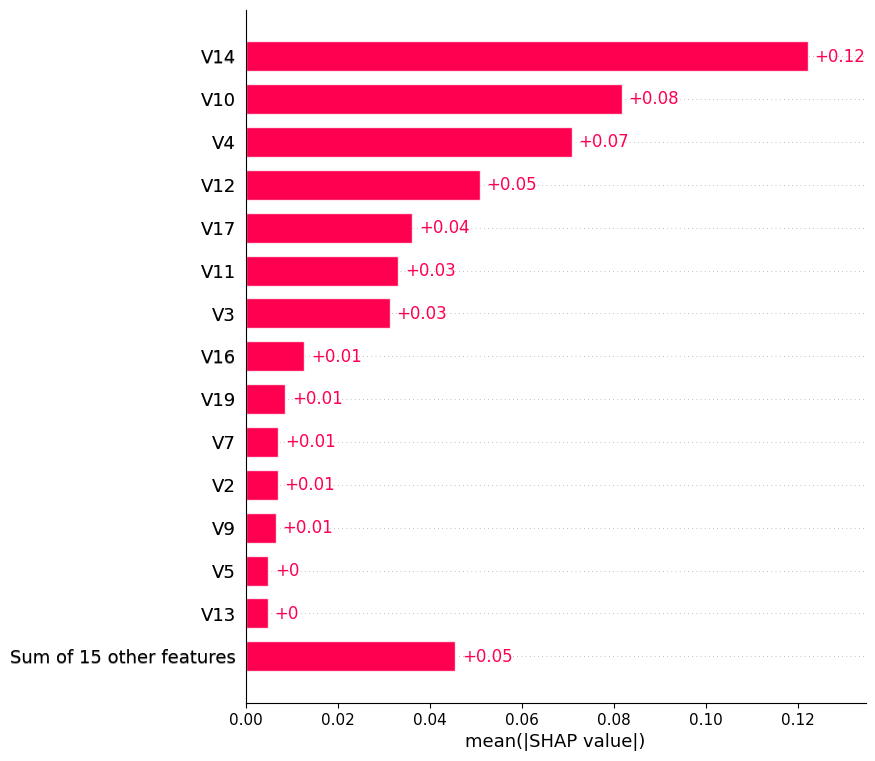

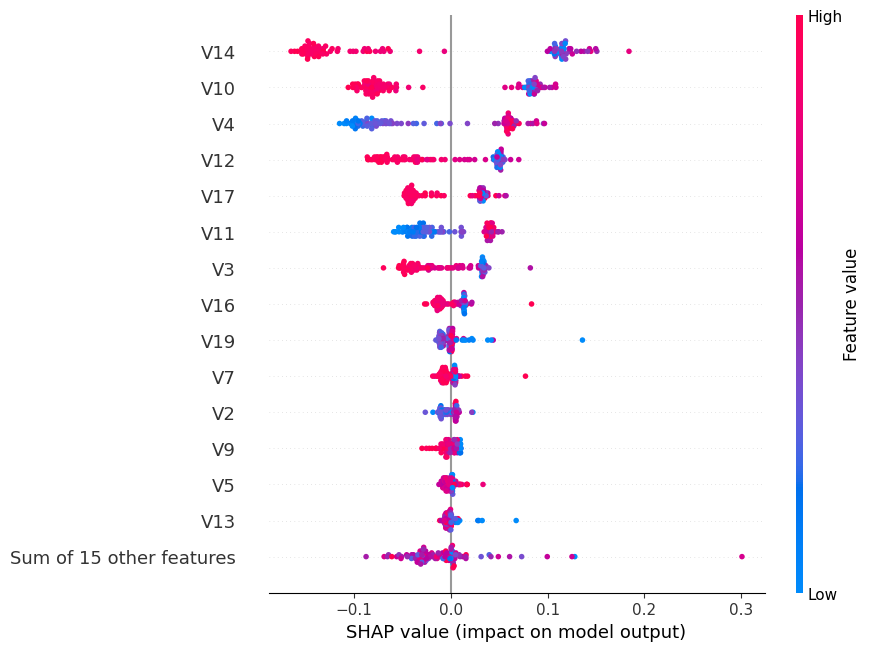


--- Task 3: Model Explainability Complete ---
Please review the generated SHAP plots to understand the key drivers of fraud in each dataset.


In [ ]:
#Interpreting Random Forest Model for Fraud_Data.csv

explainer_rf_fraud = shap.Explainer(rf_fraud, X_fraud_train_res)

shap_sample_fraud = X_fraud_train_res.sample(n=100, random_state=42)
shap_values_rf_fraud = explainer_rf_fraud(shap_sample_fraud)

shap.plots.bar(shap_values_rf_fraud[:, :, 1], max_display=15)
shap.plots.beeswarm(shap_values_rf_fraud[:, :, 1], max_display=15)

#Interpret Best-Performing Model for Creditcard.csv (Random Forest)
explainer_rf_creditcard = shap.Explainer(rf_creditcard, X_creditcard_train_res)
shap_sample_creditcard = X_creditcard_train_res.sample(n=min(100, X_creditcard_train_res.shape[0]), random_state=42)
shap_values_rf_creditcard = explainer_rf_creditcard(shap_sample_creditcard)

shap.plots.bar(shap_values_rf_creditcard[:, :, 1], max_display=15)
shap.plots.beeswarm(shap_values_rf_creditcard[:, :, 1], max_display=15)
